# Problem Set 3

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**

## Abalone

This is a problem about Abalone...but not really. You should be able to use common knowledge to work with the data in this problem.

```
Description of fields in abalone data.

Name            Data Type    Meas.    Description
----            ---------    -----    -----------
Sex             nominal               M, F, and I (infant)
Length          continuous    mm      Longest shell measurement
Diameter        continuous    mm      perpendicular to length
Height          continuous    mm      with meat in shell
Whole weight    continuous    grams   whole abalone
Shucked weight  continuous    grams   weight of meat
Viscera weight  continuous    grams   gut weight (after bleeding)
Shell weight    continuous    grams   after being dried
Rings           integer               +1.5 gives the age in years
```

The target variable is Rings because it is a predictor of age. You can take this as your problem, "How do we estimate the age of an abalone from the available data?"

At a high level you have:

1. Question/Problem
2. ETL
3. EDA
4. Statistical and Mathematical Modeling.

Of necessity, there is very little ETL here except to verify that the data has loaded correctly and with the correct types. For the EDA and Modeling parts, follow the guidelines in *Fundamentals*.


**Begin**

In [1]:
import numpy as np
import random as py_random
import numpy.random as np_random
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
sns.set(style="whitegrid")


## Objective 

In below analysis, we will try to answer the question that if we can estimate the age (ring) of an abalone based on various attributes of abalone including sex, legth, diameter, height, and various weights.

### ETL

We will start with load the csv data into pandas data frame and get a brief idea about the data

In [2]:
pd.read_csv('abalone.original.csv').head()

,M,91,73,19,102.8,44.9,20.2,30,15
0,M,70,53,18,45.1,19.9,9.7,14.0,7
1,F,106,84,27,135.4,51.3,28.3,42.0,9
2,M,88,73,25,103.2,43.1,22.8,31.0,10
3,I,66,51,16,41.0,17.9,7.9,11.0,7
4,I,85,60,19,70.3,28.2,15.5,24.0,8


The data doesn't seem to have header row, we will add the header names based on the information given above

In [3]:
# ETL
colnames=['sex', 'length', 'diameter', 'height', 'wholeweight', 'shuckedweight', 'visceraweight', 'shellweight', 'rings']

data = pd.read_csv('abalone.original.csv', header = None, names = colnames)
data.head()

,sex,length,diameter,height,wholeweight,shuckedweight,visceraweight,shellweight,rings
0,M,91,73,19,102.8,44.9,20.2,30.0,15
1,M,70,53,18,45.1,19.9,9.7,14.0,7
2,F,106,84,27,135.4,51.3,28.3,42.0,9
3,M,88,73,25,103.2,43.1,22.8,31.0,10
4,I,66,51,16,41.0,17.9,7.9,11.0,7


Data is now successfully loaded into dataframe, we will also check the amount of data and data types

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
sex              4177 non-null object
length           4177 non-null int64
diameter         4177 non-null int64
height           4177 non-null int64
wholeweight      4177 non-null float64
shuckedweight    4177 non-null float64
visceraweight    4177 non-null float64
shellweight      4177 non-null float64
rings            4177 non-null int64
dtypes: float64(4), int64(4), object(1)
memory usage: 293.8+ KB


#### Correlations

Before we start any analysis, we also want to get an idea about the correlations among variables first

                 length  diameter    height  wholeweight  shuckedweight  \
length         1.000000  0.986812  0.827554     0.925261       0.897914   
diameter       0.986812  1.000000  0.833684     0.925452       0.893162   
height         0.827554  0.833684  1.000000     0.819221       0.774972   
wholeweight    0.925261  0.925452  0.819221     1.000000       0.969405   
shuckedweight  0.897914  0.893162  0.774972     0.969405       1.000000   
visceraweight  0.903018  0.899724  0.798319     0.966375       0.931961   
shellweight    0.897706  0.905330  0.817338     0.955355       0.882617   
rings          0.556720  0.574660  0.557467     0.540390       0.420884   

               visceraweight  shellweight     rings  
length              0.903018     0.897706  0.556720  
diameter            0.899724     0.905330  0.574660  
height              0.798319     0.817338  0.557467  
wholeweight         0.966375     0.955355  0.540390  
shuckedweight       0.931961     0.882617  0.420884  


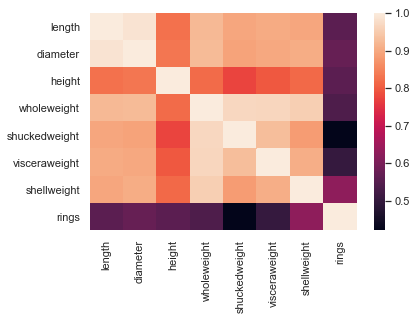

In [5]:
#correlations
corr = data.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Different weights are highly correlated to each other as expected. Furthermore, we also see size (i.e. length, height, diameters) are all highly correlated to the weight. This makes sense as we would expect bigger the abalone, the heavier it is.

Other than that, we see rings (age) is somewhat correlated to other attributes, we will look into the relationships of each attribute in the analysis below

### Single Variable Analysis

Now we will start look into each of the variables to get a better understanding of them

### Sex

In [6]:
data.sex.describe()

count     4177
unique       3
top          M
freq      1528
Name: sex, dtype: object

In [7]:
pd.DataFrame(data.sex.value_counts().sort_index())

,sex
F,1307
I,1342
M,1528


In [8]:
pd.DataFrame(data.sex.value_counts( normalize=True).sort_index())

,sex
F,0.312904
I,0.321283
M,0.365813


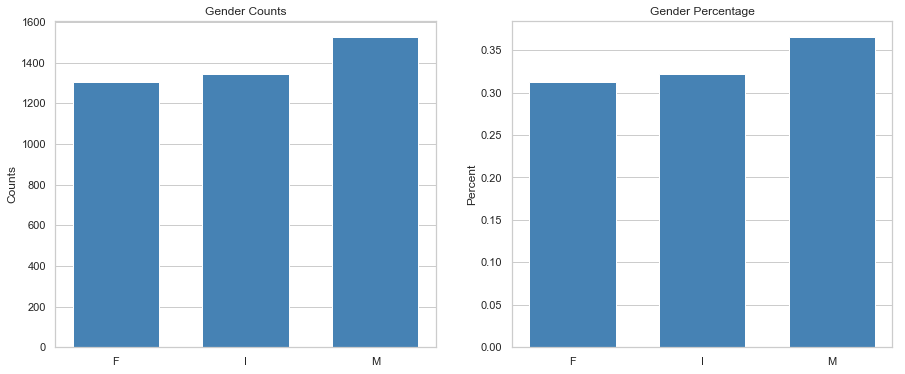

In [9]:
counts = data.sex.value_counts().sort_index()
proportions = data.sex.value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5
figure = plt.figure(figsize=(15, 6))
axes = figure.add_subplot(1, 2, 1)
axes.bar(x, counts, width, color="steelblue", align="center")
axes.set_xticks([0, 1,2])
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Gender Counts")
axes.set_ylabel( "Counts")
axes.xaxis.grid(False)

axes = figure.add_subplot(1, 2, 2)
axes.bar(x, proportions, width, color="steelblue", align="center")
axes.set_xticks([0, 1,2])
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Gender Percentage")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)


We can see sex is fairly evenly distributed among male, female, and infaint with male has a bit higher at 36.58%

### Length

In [10]:
#Descriptive Statistics
data.length.describe().round()

count    4177.0
mean      105.0
std        24.0
min        15.0
25%        90.0
50%       109.0
75%       123.0
max       163.0
Name: length, dtype: float64

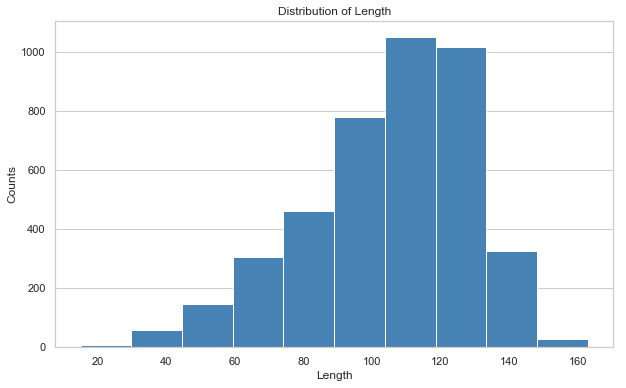

In [11]:
#Length Distribution
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.length, color="steelblue")
axes.set_title("Distribution of Length")
axes.set_xlabel("Length")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

The distribution of the length is left skewed with mean at 105.

### diameter

In [12]:
#Descriptive Statistics
data.diameter.describe().round()

count    4177.0
mean       82.0
std        20.0
min        11.0
25%        70.0
50%        85.0
75%        96.0
max       130.0
Name: diameter, dtype: float64

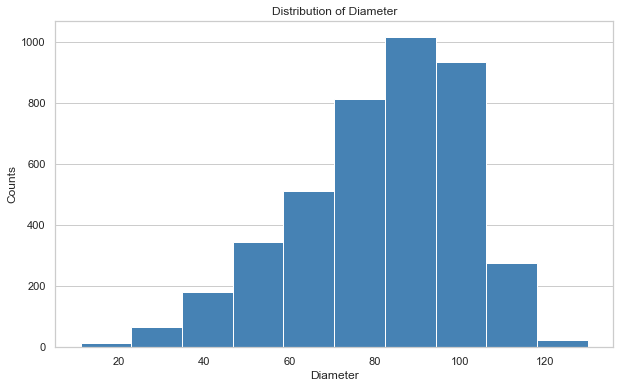

In [13]:
#Length Distribution
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.diameter, color="steelblue")
axes.set_title("Distribution of Diameter")
axes.set_xlabel("Diameter")
axes.set_ylabel("Counts")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Length has the similar left skewed distribution as diameter with its mean at 82.

### Height

In [14]:
data.height.describe().round()

count    4177.0
mean       28.0
std         8.0
min         0.0
25%        23.0
50%        28.0
75%        33.0
max       226.0
Name: height, dtype: float64

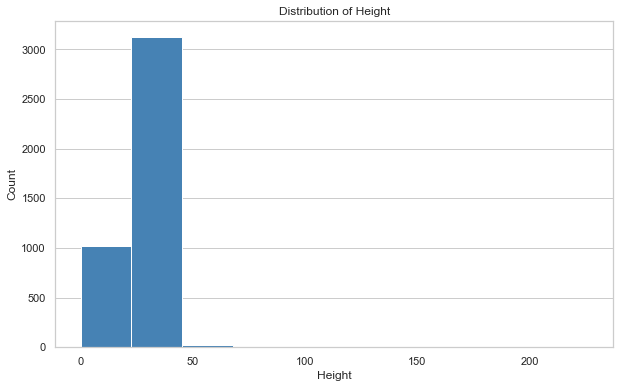

In [15]:
#Height Distribution

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1,1,1)
axes.hist(data.height,color = 'steelblue')
axes.set_title("Distribution of Height")
axes.set_xlabel("Height")
axes.set_ylabel("Count")
axes.set_xlabel("Height")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()


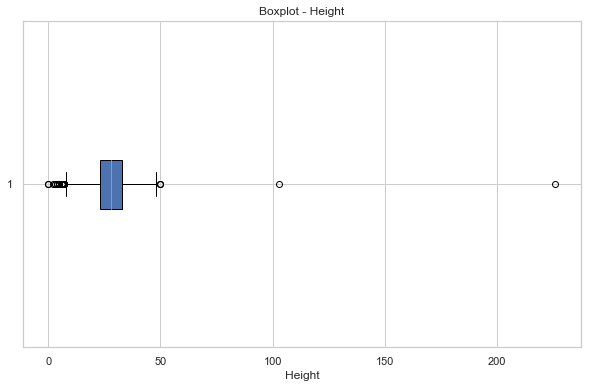

In [16]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.boxplot(data.height, patch_artist=True, zorder=1, vert=False)
axes.set_xlabel("Height")
axes.set_title("Boxplot - Height")
plt.show()
plt.close()


We can see most of the heights are gathered within a particular range. Based on the boxplot, we can see our IQR is between 23 to 33 with the mean at 28

### whole weight + shucked weight + visceraweight + shellweight

As weights are all highly correlated based on our correlation graph, we will do their analysis together

In [17]:
data.wholeweight.describe().round()



count    4177.0
mean      166.0
std        98.0
min         0.0
25%        88.0
50%       160.0
75%       231.0
max       565.0
Name: wholeweight, dtype: float64

In [18]:
data.shuckedweight.describe().round()

count    4177.0
mean       72.0
std        44.0
min         0.0
25%        37.0
50%        67.0
75%       100.0
max       298.0
Name: shuckedweight, dtype: float64

In [19]:
data.visceraweight.describe().round()

count    4177.0
mean       36.0
std        22.0
min         0.0
25%        19.0
50%        34.0
75%        51.0
max       152.0
Name: visceraweight, dtype: float64

In [20]:
data.shellweight.describe().round()

count    4177.0
mean       48.0
std        28.0
min         0.0
25%        26.0
50%        47.0
75%        66.0
max       201.0
Name: shellweight, dtype: float64

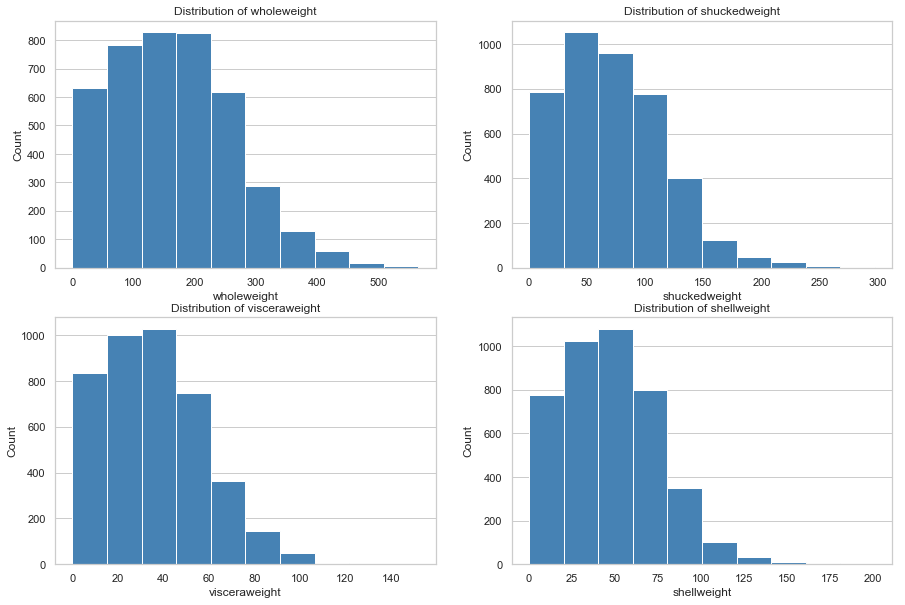

In [21]:
#Weight Distribution

figure = plt.figure(figsize=(15,10))

axes = figure.add_subplot(2,2,1)
axes.hist(data.wholeweight,color = 'steelblue')
axes.set_title("Distribution of wholeweight")
axes.set_xlabel("wholeweight")
axes.set_ylabel("Count")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)

axes = figure.add_subplot(2,2,2)
axes.hist(data.shuckedweight,color = 'steelblue')
axes.set_title("Distribution of shuckedweight")
axes.set_xlabel("shuckedweight")
axes.set_ylabel("Count")
axes.set_xlabel("shuckedweight")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)

axes = figure.add_subplot(2,2,3)
axes.hist(data.visceraweight,color = 'steelblue')
axes.set_title("Distribution of visceraweight")
axes.set_xlabel("visceraweight")
axes.set_ylabel("Count")
axes.set_xlabel("visceraweight")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)

axes = figure.add_subplot(2,2,4)
axes.hist(data.shellweight,color = 'steelblue')
axes.set_title("Distribution of shellweight")
axes.set_xlabel("shellweight")
axes.set_ylabel("Count")
axes.set_xlabel("shellweight")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)



plt.show()
plt.close()

We can see weights all have similar shape right skewed normal distributions

### Ring

In [22]:
data.rings.describe().round()

count    4177.0
mean       10.0
std         3.0
min         1.0
25%         8.0
50%         9.0
75%        11.0
max        29.0
Name: rings, dtype: float64

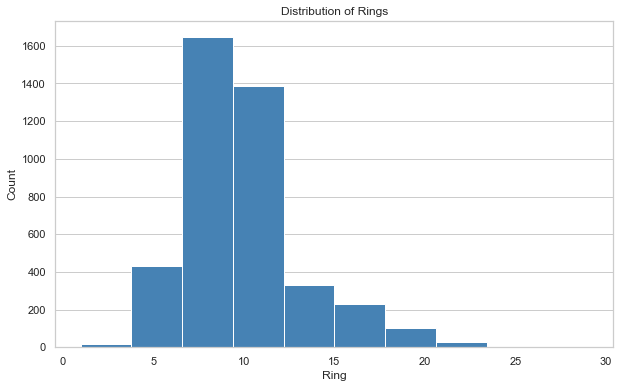

In [23]:
#Ring Distribution

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1,1,1)
axes.hist(data.rings,color = 'steelblue')
axes.set_title("Distribution of Rings")
axes.set_xlabel("Ring")
axes.set_ylabel("Count")
axes.set_xlabel("Ring")
axes.yaxis.grid( b=True, which="major")
axes.xaxis.grid(False)
plt.show()
plt.close()

Ring has a slightly right skewed normal distribution with mean at 10

### Relationship Analysis Ring vs. Other Variables

### Ring vs Sex

In [24]:
grouped = data.groupby( "sex")
grouped_y = grouped["rings"].describe()
print(grouped_y)


      count       mean       std  min  25%   50%   75%   max
sex                                                         
F    1307.0  11.129304  3.104256  5.0  9.0  10.0  12.0  29.0
I    1342.0   7.890462  2.511554  1.0  6.0   8.0   9.0  21.0
M    1528.0  10.705497  3.026349  3.0  9.0  10.0  12.0  27.0


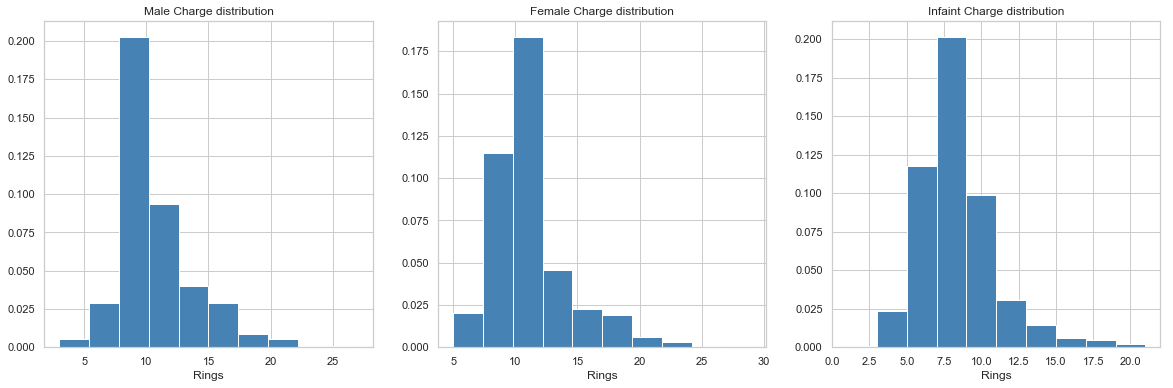

In [25]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 3, 1)
axes.hist(grouped["rings"].get_group("M"),color="steelblue",density=True)
axes.set_title("Male Charge distribution")
axes.set_xlabel("Rings")

axes = figure.add_subplot(1, 3, 2)
axes.hist(grouped["rings"].get_group("F"),color="steelblue",density=True)
axes.set_title("Female Charge distribution")
axes.set_xlabel("Rings")

axes = figure.add_subplot(1, 3, 3)
axes.hist(grouped["rings"].get_group("I"),color="steelblue",density=True)
axes.set_title("Infaint Charge distribution")
axes.set_xlabel("Rings")


plt.show()
plt.close()

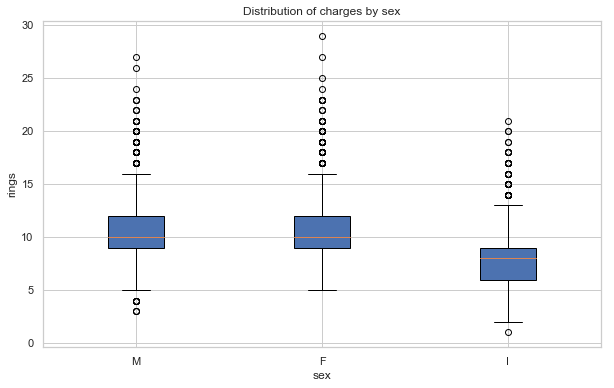

In [26]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
labels = pd.unique(data["sex"].values)
grouped_data = [grouped[ "rings"].get_group( k) for k in labels]
patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
axes.set_xlabel("sex")
axes.set_ylabel("rings")
axes.set_title("Distribution of charges by sex")
plt.show()
plt.close()

Distribution and range of the rings doesn't change much between male and female with the mean at around 11. However, Infaints are observed to have lower ranges and IQR with mean at approximately 8.

### Rings vs. length

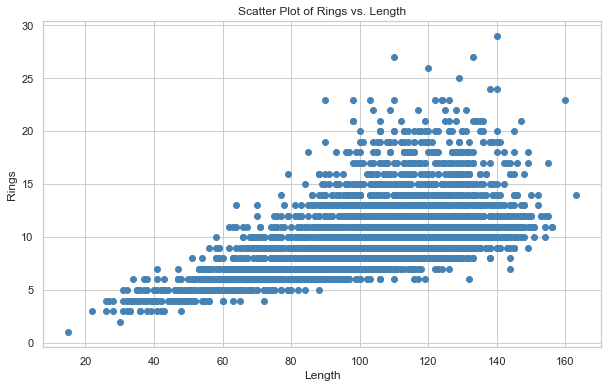

In [27]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.length, data.rings, marker="o", color="steelblue")

axes.set_ylabel("Rings")
axes.set_xlabel("Length")
axes.set_title("Scatter Plot of Rings vs. Length")

plt.show()
plt.close()

There is a positive relationship between rings and length which means longer the lengths, older the abalone. This estimation is more accurate for younger abalones as we see the variations increase more and more when abalone is older

### Rings vs. Diameter

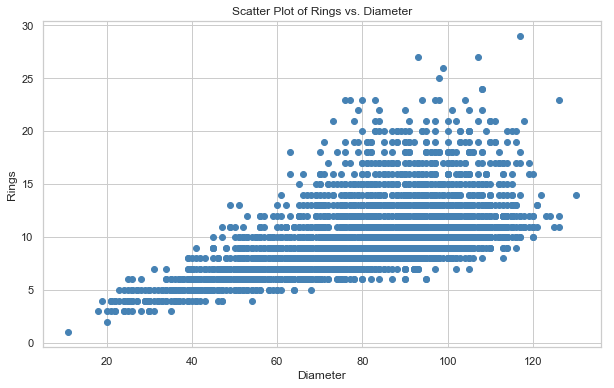

In [28]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.diameter, data.rings, marker="o", color="steelblue")

axes.set_ylabel("Rings")
axes.set_xlabel("Diameter")
axes.set_title("Scatter Plot of Rings vs. Diameter")

plt.show()
plt.close()

There is a positive relationship between rings and diameter of the abalone which means longer the diameter, older the abalone. This estimation is more accurate for younger abalones as we see the variations increase more and more when abalone is older

### Rings vs. Height

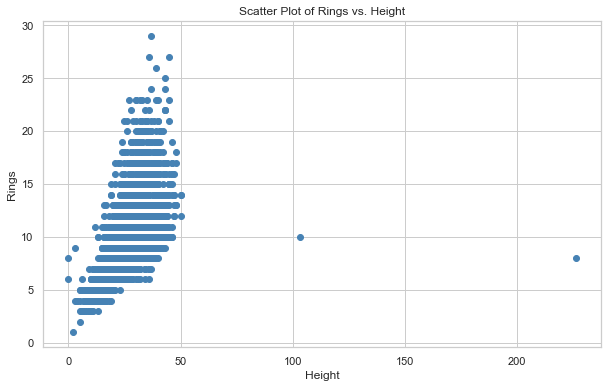

In [29]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.height, data.rings, marker="o", color="steelblue")

axes.set_ylabel("Rings")
axes.set_xlabel("Height")
axes.set_title("Scatter Plot of Rings vs. Height")

plt.show()
plt.close()

There is a positive relationship between rings and diameter of the abalone which means higher the height, older the abalone. The relationship tends to be exponential as we see the curve is fairly steep.

### Rings vs whole weight + shuckedweight + visceraweight + shellweight

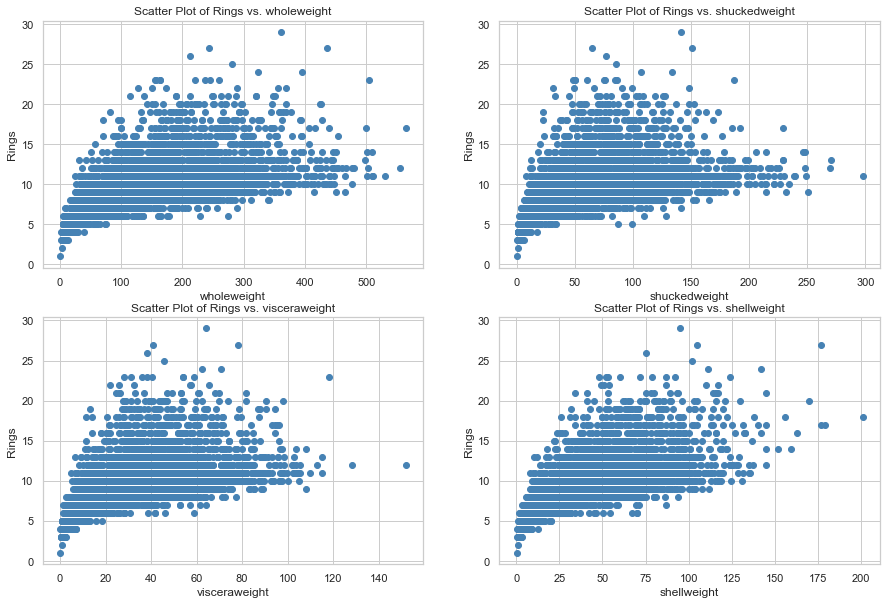

In [30]:
figure = plt.figure(figsize=(15, 10))

axes = figure.add_subplot(2, 2, 1)
axes.scatter(data.wholeweight, data.rings, marker="o", color="steelblue")

axes.set_ylabel("Rings")
axes.set_xlabel("wholeweight")
axes.set_title("Scatter Plot of Rings vs. wholeweight")


axes = figure.add_subplot(2,2,2)
axes.scatter(data.shuckedweight, data.rings, marker="o", color="steelblue")

axes.set_ylabel("Rings")
axes.set_xlabel("shuckedweight")
axes.set_title("Scatter Plot of Rings vs. shuckedweight")

axes = figure.add_subplot(2,2,3)
axes.scatter(data.visceraweight, data.rings, marker="o", color="steelblue")

axes.set_ylabel("Rings")
axes.set_xlabel("visceraweight")
axes.set_title("Scatter Plot of Rings vs. visceraweight")

axes = figure.add_subplot(2,2,4)
axes.scatter(data.shellweight, data.rings, marker="o", color="steelblue")

axes.set_ylabel("Rings")
axes.set_xlabel("shellweight")
axes.set_title("Scatter Plot of Rings vs. shellweight")

plt.show()
plt.close()

There is a positive relationship between rings and weights of the abalone which means heavier the weight, older the abalone. Also the relationship seems to be log relationship as the increase in rings slow down as the weight increases.

### Summary

In summary, we see height, length, diameters, weights all have positive relationships with age (ring) of abalone where the relationship seems to be linear for length and diameter, exponential for height, and log for weights. In addition, infaints sex  usually leads to lower age compared to male and female.